In [1]:
import pandas as pd
import numpy as np
import pprint
import re

from keras.models import Model
from keras.layers import Input, Embedding, Flatten, Dense, Concatenate
from keras.layers import Dropout, BatchNormalization, Activation
from keras.regularizers import l2
from keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
import tensorflow as tf

import tensorflow_datasets as tfds

In [7]:
model = tf.keras.models.load_model('../models/reco_v2.h5')
df = pd.read_csv('../../../data/ML1m_merged.csv')
links = pd.read_csv('../../../data/movielens/links.csv')

def extract_year(row):
    match = re.findall(r'\((\d{4})\)', row)[0]
    if match:
        return int(match)
    return None

def extract_movie_id(row):
    match = re.findall(r'\'(\d{1,7})\'', row)[0]
    if match:
        return int(match)
    return None

links.rename(columns={'movieId':'movie_id'},inplace=True)
df['year_of_release'] = df['movie_title'].apply(extract_year)
df['movie_id'] = df['movie_id'].apply(extract_movie_id)
df['movie_title'] = df['movie_title'].apply(lambda x: x[1:])

df = df.merge(links[['movie_id','imdbId']], how='left', on='movie_id')

In [5]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


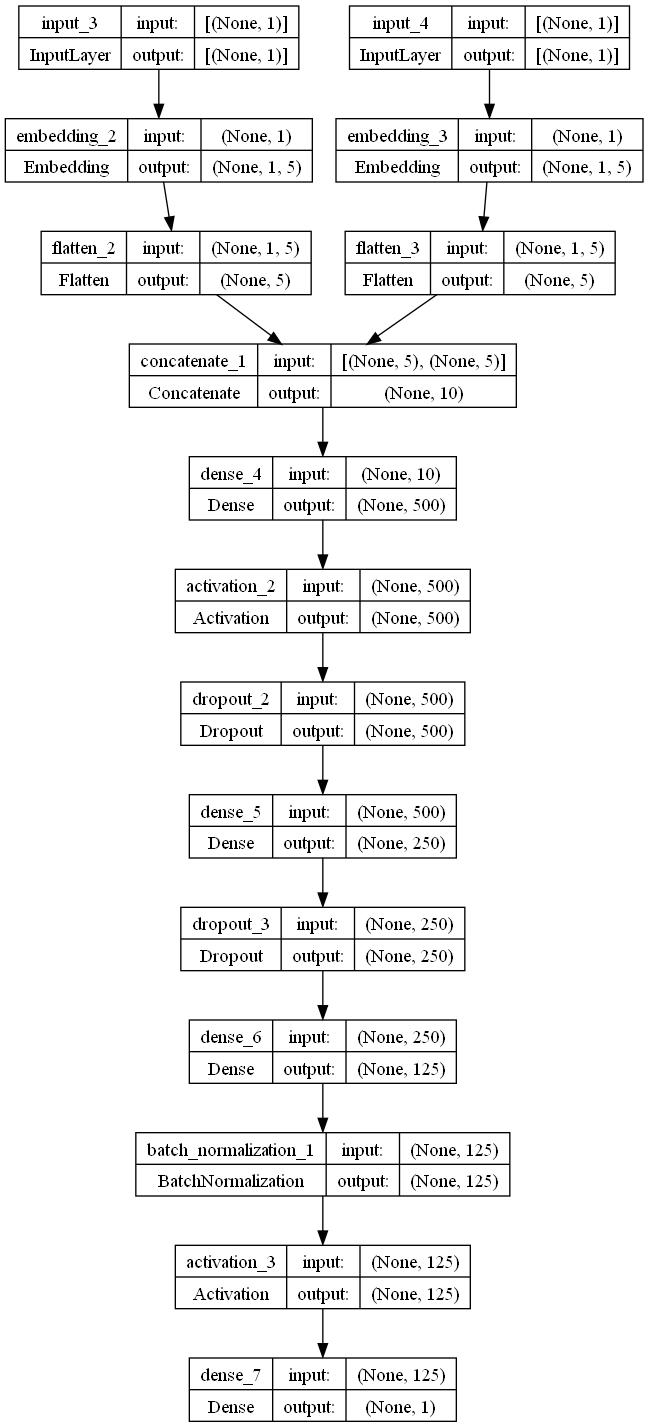

In [25]:
# plot_model(model, show_shapes=True, expand_nested=True, to_file='../../../images/model.jpg')

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 1, 5)         30200       ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, 1, 5)         18530       ['input_4[0][0]']                
                                                                                            

In [27]:
movie_id_map = {movie_id:idx for idx, movie_id in enumerate(df['movie_id'].unique())}
user_id_map = {user_id:idx for idx, user_id in enumerate(df['user_id'].unique())}

In [28]:
movie_ids = list(movie_id_map.keys())
indices = list(movie_id_map.values())

movie_mappings_df = pd.DataFrame({
    'movie_id':movie_ids,
    'movieId':indices
})


In [29]:
user_ids = list(user_id_map.keys())
user_indices = list(user_id_map.values())

user_mappings_df = pd.DataFrame({
    'movie_id':user_ids,
    'movieId':user_indices
})

In [30]:
user_mappings_df

,movie_id,movieId
0,b'130',0
1,b'3829',1
2,b'1265',2
3,b'2896',3
4,b'5264',4
...,...,...
6035,b'4264',6035
6036,b'2657',6036
6037,b'2626',6037
6038,b'318',6038


In [31]:
df.head()

,bucketized_user_age,movie_genres,movie_id,movie_title,user_gender,user_id,user_occupation_label,user_rating,movieId,userId,year_of_release
0,35.0,[0 7],b'3107','Backdraft (1991)',True,b'130',18,5.0,0,0,1991
1,25.0,[7],b'2114',"'Outsiders, The (1983)'",False,b'3829',0,4.0,1,1,1983
2,18.0,[ 4 15],b'256','Junior (1994)',False,b'1265',21,1.0,2,2,1994
3,18.0,[ 0 10],b'1389','Jaws 3-D (1983)',True,b'2896',14,5.0,3,3,1983
4,18.0,[0],b'3635',"'Spy Who Loved Me, The (1977)'",True,b'5264',17,4.0,4,4,1977


In [32]:
#Getting some user ratings

df.sort_values('year_of_release', ascending=False)



,bucketized_user_age,movie_genres,movie_id,movie_title,user_gender,user_id,user_occupation_label,user_rating,movieId,userId,year_of_release
486475,56.0,[ 0 15],b'3793','X-Men (2000)',True,b'3618',18,3.0,881,1492,2000
839009,56.0,[2 3],b'3615','Dinosaur (2000)',True,b'5470',6,4.0,499,4235,2000
494376,1.0,[0],b'3624','Shanghai Noon (2000)',True,b'4541',17,4.0,595,2418,2000
716207,25.0,[ 7 16],b'3510','Frequency (2000)',True,b'5038',21,2.0,517,1714,2000
926203,35.0,[7],b'3408','Erin Brockovich (2000)',True,b'956',0,4.0,186,549,2000
...,...,...,...,...,...,...,...,...,...,...,...
931336,50.0,[4],b'3132','Daddy Long Legs (1919)',False,b'1631',11,3.0,2166,1065,1919
981478,18.0,[1 7],b'2821','Male and Female (1919)',True,b'1470',17,2.0,3487,762,1919
267101,45.0,[4],b'3132','Daddy Long Legs (1919)',True,b'3261',21,4.0,2166,627,1919
98356,45.0,[4],b'3132','Daddy Long Legs (1919)',True,b'5056',0,5.0,2166,3582,1919


In [33]:
mu =  df['user_rating'].mean()

In [34]:
user_id_input = np.array([200])
movie_id_input = np.array([5])

prediction = model.predict([user_id_input, movie_id_input])
predicted_rating = np.round(prediction+mu).clip(1,10)
print(f"Predicted rating for user ur0011762 and movie tt0109128 is {predicted_rating}")

1/1 [==============================] - 0s 101ms/step
Predicted rating for user ur0011762 and movie tt0109128 is [[2.]]


In [33]:
df2 = pd.read_csv('../../../data/movies2013-2023_MF.csv')

In [34]:
df2.to_parquet('../../../data/movies2013-2023_MF.parquet')